/Library/Python/2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Grand Epoch: 1 / 1
Segment: seg0
Train on 7500 samples, validate on 10000 samples
Epoch 1/4
7500/7500 [==============================] - 1s 173us/step - loss: 0.5946 - acc: 0.8280 - val_loss: 0.2856 - val_acc: 0.9161
Epoch 2/4
7500/7500 [==============================] - 1s 129us/step - loss: 0.2304 - acc: 0.9327 - val_loss: 0.2145 - val_acc: 0.9345
Epoch 3/4
7500/7500 [==============================] - 1s 129us/step - loss: 0.1505 - acc: 0.9564 - val_loss: 0.2147 - val_acc: 0.9348
Epoch 4/4
7500/7500 [==============================] - 1s 129us/step - loss: 0.1141 - acc: 0.9651 - val_loss: 0.1858 - val_acc: 0.9433
Segment: seg1
Train on 7500 samples, validate on 10000 samples
Epoch 1/4
7500/7500 [==============================] - 1s 177us/step - loss: 0.6454 - acc: 0.8077 - val_loss: 0.2694 - val_acc: 0.9244
Epoch 2/4
7500/7500 [==============================] - 1s 137us/step - loss: 0.2402 - acc: 0.9311 - val_loss: 0.1951 - val_acc: 0.9409
Epoch 3/4
7500/7500 [========================

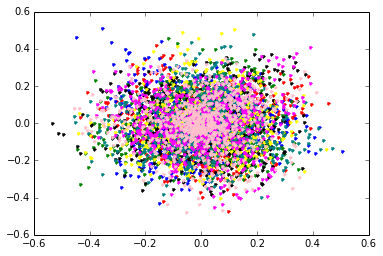

In [2]:
%matplotlib inline
from __future__ import print_function
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import clone_model
import numpy as np
import pandas
import matplotlib.pyplot as plt
import math
from scipy import linalg as la

class distributed_model_training:

    def __init__(self):
        self.num_classes = 10
        self.total_num_epochs = 1 #Can tune
        self.batch_size = 100
        self.num_segments = 8 #Can tune
        self.num_iters_on_segment = 4 #Can tune
        self.weights_plotter = pca_weights_plotter()
        self.get_data()
        self.distribute_data()
        self.define_models()
        self.train_model_aggregate()

    def tensorflow_test(self):
        hello = tf.constant('Hello, TensorFlow!')
        sess = tf.Session()
        print(sess.run(hello))

    def get_data(self):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = x_train.reshape(60000, 784)
        x_test = x_test.reshape(10000, 784)
        self.y_train = y_train.reshape(60000, 1)
        self.y_test = y_test.reshape(10000, 1)
        self.x_train = x_train.astype('float32')
        self.x_test = x_test.astype('float32')
        self.x_train /= 255
        self.x_test /= 255
        # One-hot encode the y vectors
        self.y_train = keras.utils.to_categorical(self.y_train, self.num_classes)
        self.y_test = keras.utils.to_categorical(self.y_test, self.num_classes)

    def distribute_data(self):
        # Shuffle? np.random.shuffle(self.x_train)
        self.segment_batches = {}
        data_per_segment = int(math.floor(60000/self.num_segments))
        for i in range(self.num_segments):
            self.segment_batches["seg"+str(i)] = (self.x_train[data_per_segment*i:data_per_segment*i+data_per_segment],
                                                  self.y_train[data_per_segment*i:data_per_segment*i+data_per_segment])

        #for i in range(self.num_segments):
        #	self.segment_batches["seg"+str(i)] = (self.x_train, self.y_train)

    def define_models(self):
        self.segment_models = {}
        for i in range(self.num_segments):
            model = Sequential()
            model.add(Dense(512, activation='relu', input_shape=(784,)))
            model.add(Dropout(0.2))
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(self.num_classes, activation='softmax'))
            self.segment_models["seg"+str(i)] = model

    def train_model_aggregate(self):
        # Training and evaluation loop
        for i in range(self.total_num_epochs):
            print("Grand Epoch:", i+1, "/", self.total_num_epochs)

            # Train individual models for 5 epochs
            colors = iter(['red', 'blue', 'green', 'black', 'yellow', 'teal', 'magenta', 'pink', 'skyblue', 'cyan'])
            for segment in sorted(self.segment_models):
                print('Segment:', segment)
                (x_train_seg, y_train_seg) = self.segment_batches[segment]
                model_seg = self.segment_models[segment]
                model_seg.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['accuracy'])
                history = model_seg.fit(x_train_seg, y_train_seg,
                    batch_size=self.batch_size,
                    epochs=self.num_iters_on_segment,
                    verbose=1,
                    validation_data=(self.x_test, self.y_test))
                data = model_seg.get_weights()[0]
                color = next(colors)
                self.weights_plotter.plot_data(data, color) if i == self.total_num_epochs-1 else None
        
    def testingstuff(self):
        # Re-define the aggregate model (stored on the master node, and ultimately returned), also re-initialize its weights
        self.aggregate_model = Sequential()
        self.aggregate_model.add(Dense(512, activation='relu', input_shape=(784,)))
        self.aggregate_model.add(Dropout(0.2))
        self.aggregate_model.add(Dense(512, activation='relu'))
        self.aggregate_model.add(Dropout(0.2))
        self.aggregate_model.add(Dense(self.num_classes, activation='softmax'))
        
        # Average the weights of the trained models on the segments, add these weights to the aggregate model
        avg_weights = sum([np.array(self.segment_models[segment].get_weights())*np.random.random()*32 for segment in self.segment_models])/self.num_segments
        self.aggregate_model.set_weights(avg_weights)

        # Compile aggregate model
        self.aggregate_model.compile(loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy'])

        # Evaluate aggregate model on the test set
        score = self.aggregate_model.evaluate(self.x_test, self.y_test, verbose=1)
        print(score)

        self.weights_plotter.plot_data(self.aggregate_model.get_weights()[0], "orange", 'x')
        self.weights_plotter.show_plot()
        
        # Conduct final testing of aggregate model
        train_score = self.aggregate_model.evaluate(self.x_train, self.y_train, verbose=1)
        test_score = self.aggregate_model.evaluate(self.x_test, self.y_test, verbose=1)
        print("Training accuracy:", train_score[1])
        print("Test accuracy:", test_score[1])


class pca_weights_plotter:

    def __init__(self):
        self.fig = plt.figure()

    def plot_data(self, data, color, symbol='.', num_dims_to_keep=2):
        self.data = data
        self.m, self.n = self.data.shape
        self.num_dims_to_keep = num_dims_to_keep
        self.color = color
        self.symbol = symbol
        self.plot_PCA()
        # self.test_PCA()

    def PCA(self):
        data_mean_normalized = self.data - self.data.mean(axis=0)
        R = np.cov(data_mean_normalized, rowvar=False)
        evals, evecs = la.eigh(R)
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        evecs = evecs[:, :self.num_dims_to_keep]
        return np.dot(evecs.T, data_mean_normalized.T).T, evals, evecs

    def test_PCA(self):
        _, _, eigenvectors = self.PCA()
        data_recovered = np.dot(eigenvectors, self.m).T
        data_recovered += data_recovered.mean(axis=0)
        assert np.allclose(self.data, data_recovered)

    def plot_PCA(self):
        ax1 = self.fig.add_subplot(111)
        data_resc, evals, evecs = self.PCA()
        ax1.plot(data_resc[:, 0], data_resc[:, 1], self.symbol, mfc=self.color, mec=self.color)

    def show_plot(self):
        plt.show()


model_instance = distributed_model_training()

In [3]:
%matplotlib inline
def testingstuff(self):
    # Re-define the aggregate model (stored on the master node, and ultimately returned), also re-initialize its weights
    self.aggregate_model = Sequential()
    self.aggregate_model.add(Dense(512, activation='relu', input_shape=(784,)))
    self.aggregate_model.add(Dropout(0.2))
    self.aggregate_model.add(Dense(512, activation='relu'))
    self.aggregate_model.add(Dropout(0.2))
    self.aggregate_model.add(Dense(self.num_classes, activation='softmax'))

    # Average the weights of the trained models on the segments, add these weights to the aggregate model
    avg_weights = sum([np.array(self.segment_models[segment].get_weights())*np.random.random()*128 for segment in self.segment_models])/self.num_segments
    self.aggregate_model.set_weights(avg_weights)

    # Compile aggregate model
    self.aggregate_model.compile(loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy'])

    # Evaluate aggregate model on the test set
    score = self.aggregate_model.evaluate(self.x_test, self.y_test, verbose=1)
    print(score)

    self.weights_plotter.plot_data(self.aggregate_model.get_weights()[0], "orange", 'x')
    self.weights_plotter.show_plot()

    # Conduct final testing of aggregate model
    train_score = self.aggregate_model.evaluate(self.x_train, self.y_train, verbose=1)
    test_score = self.aggregate_model.evaluate(self.x_test, self.y_test, verbose=1)
    print("Training accuracy:", train_score[1])
    print("Test accuracy:", test_score[1])
    
# model_instance.testingstuff = testingstuff
import types
model_instance.testingstuff = types.MethodType( testingstuff, model_instance )
model_instance.testingstuff()

10000/10000 [==============================] - 1s 67us/step
[8.65465991973877, 0.4618]
10000/10000 [==============================] - 0s 45us/step
Training accuracy: 0.4573333333333333
Test accuracy: 0.4618
